<a href="https://colab.research.google.com/github/coleb9/Time-Series-Project/blob/main/Time_Series_Project_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Project — Electricity Load & Renewable Forecasting

This notebook contains the full workflow for our time series forecasting project:

- Loading and preparing the OPSD dataset
- Feature engineering
- Creating sliding windows
- Building LSTM, GRU, and Transformer models
- Training and evaluating models
- Comparing performance


# Pre-Processing

In [1]:
from google.colab import files
uploaded = files.upload()

Saving time_series_60min_singleindex.csv to time_series_60min_singleindex.csv


In [2]:
import pandas as pd

df = pd.read_csv("time_series_60min_singleindex.csv")

# Select only the German columns we need
columns = [
    "utc_timestamp",
    "DE_load_actual_entsoe_transparency",
    "DE_wind_onshore_generation_actual",
    "DE_solar_generation_actual"
]

df = df[columns]
df.head()


,utc_timestamp,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual
0,2014-12-31T23:00:00Z,NaN,NaN,NaN
1,2015-01-01T00:00:00Z,41151.0,8336.0,NaN
2,2015-01-01T01:00:00Z,40135.0,8540.0,NaN
3,2015-01-01T02:00:00Z,39106.0,8552.0,NaN
4,2015-01-01T03:00:00Z,38765.0,8643.0,NaN


In [3]:
# Convert timestamp to proper datetime format
df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'])

# Set it as the index
df = df.set_index('utc_timestamp')

# Sort by time just to be safe
df = df.sort_index()

df.head()


,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual
utc_timestamp,,,
2014-12-31 23:00:00+00:00,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,41151.0,8336.0,NaN
2015-01-01 01:00:00+00:00,40135.0,8540.0,NaN
2015-01-01 02:00:00+00:00,39106.0,8552.0,NaN
2015-01-01 03:00:00+00:00,38765.0,8643.0,NaN


In [4]:
# Check how many missing values exist
df.isna().sum()

# Ensure all numeric columns are actually numeric (required for interpolation)
df = df.apply(pd.to_numeric, errors='coerce')

# Interpolate missing values based on time
df = df.interpolate(method='time')

# Fill any NaNs that remain at the very start or end (edges)
df = df.ffill().bfill()

# Confirm everything is filled now
df.isna().sum()


,0
DE_load_actual_entsoe_transparency,0
DE_wind_onshore_generation_actual,0
DE_solar_generation_actual,0


In [5]:
# Create time-based features
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek    # Monday=0, Sunday=6
df['month'] = df.index.month

df.head()

,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual,hour,day_of_week,month
utc_timestamp,,,,,,
2014-12-31 23:00:00+00:00,41151.0,8336.0,71.0,23,2,12
2015-01-01 00:00:00+00:00,41151.0,8336.0,71.0,0,3,1
2015-01-01 01:00:00+00:00,40135.0,8540.0,71.0,1,3,1
2015-01-01 02:00:00+00:00,39106.0,8552.0,71.0,2,3,1
2015-01-01 03:00:00+00:00,38765.0,8643.0,71.0,3,3,1


In [6]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler for all columns
scaler = MinMaxScaler()

# Fit and transform the DataFrame
scaled_values = scaler.fit_transform(df)

# Convert back to a DataFrame with the same index and column names
df_scaled = pd.DataFrame(scaled_values, index=df.index, columns=df.columns)

df_scaled.head()


,DE_load_actual_entsoe_transparency,DE_wind_onshore_generation_actual,DE_solar_generation_actual,hour,day_of_week,month
utc_timestamp,,,,,,
2014-12-31 23:00:00+00:00,0.212880,0.202225,0.002155,1.000000,0.333333,1.0
2015-01-01 00:00:00+00:00,0.212880,0.202225,0.002155,0.000000,0.500000,0.0
2015-01-01 01:00:00+00:00,0.190909,0.207245,0.002155,0.043478,0.500000,0.0
2015-01-01 02:00:00+00:00,0.168656,0.207541,0.002155,0.086957,0.500000,0.0
2015-01-01 03:00:00+00:00,0.161282,0.209780,0.002155,0.130435,0.500000,0.0


In [7]:
import numpy as np

# We will predict this column:
target_col = "DE_load_actual_entsoe_transparency"

# How many past hours to use
window_size = 24

data = df_scaled.copy()

X_list = []
y_list = []

target_idx = data.columns.get_loc(target_col)

for i in range(len(data) - window_size):
    # past 24 hours of all features
    X_list.append(data.iloc[i : i + window_size].values)
    # load value at the next hour
    y_list.append(data.iloc[i + window_size, target_idx])

X = np.array(X_list)
y = np.array(y_list)

X.shape, y.shape


((50377, 24, 6), (50377,))

In [8]:
# Sizes
n = len(X)

train_size = int(n * 0.70)
val_size = int(n * 0.15)
test_size = n - train_size - val_size

# Split chronologically
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size : train_size + val_size]
y_val = y[train_size : train_size + val_size]

X_test = X[train_size + val_size :]
y_test = y[train_size + val_size :]

X_train.shape, X_val.shape, X_test.shape


((35263, 24, 6), (7556, 24, 6), (7558, 24, 6))

# LSTM Model

In [9]:
# Build the LSTM Model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Check shapes (just to be sure)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Input shape for the LSTM: (time_steps, num_features)
input_shape = X_train.shape[1:]  # (24, num_features)

# Build a simple baseline LSTM model
baseline_lstm = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32),
    layers.Dense(1)  # predict next-hour load
])

baseline_lstm.summary()

# Compile the model
baseline_lstm.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)

# Early stopping to avoid overfitting
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Train the model
history_lstm = baseline_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)


X_train shape: (35263, 24, 6)
y_train shape: (35263,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - loss: 0.0251 - mae: 0.1055 - val_loss: 0.0027 - val_mae: 0.0399
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - loss: 0.0022 - mae: 0.0360 - val_loss: 0.0015 - val_mae: 0.0303
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - loss: 0.0013 - mae: 0.0275 - val_loss: 0.0011 - val_mae: 0.0251
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - loss: 8.9227e-04 - mae: 0.0227 - val_loss: 6.6757e-04 - val_mae: 0.0194
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 6.0595e-04 - mae: 0.0186 - val_loss: 4.3023e-04 - val_mae: 0.0157
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 4.7246e-04 - mae: 0.0164 - val_loss: 4.5194e-04 - val_mae: 0.0166
Epoch 7/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - loss: 4.2437e-04 - mae: 0.0156 - val_loss: 4.5654e-04 - val_mae: 0.0168
Epoch 8/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - loss: 3.8888e-04 - mae: 0.0149 - val_loss: 4.3456e-04 - val_mae: 0.0164


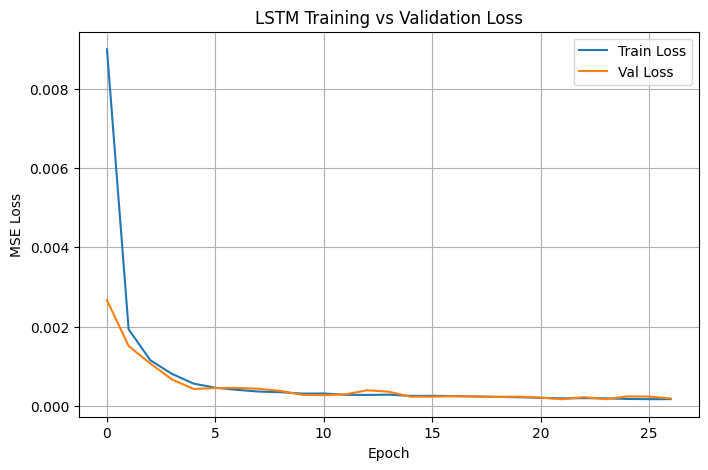

Test MSE (scaled): 0.0002
Test MAE (scaled): 0.0112
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Test MAE (MW): 517.71
Test RMSE (MW): 669.60


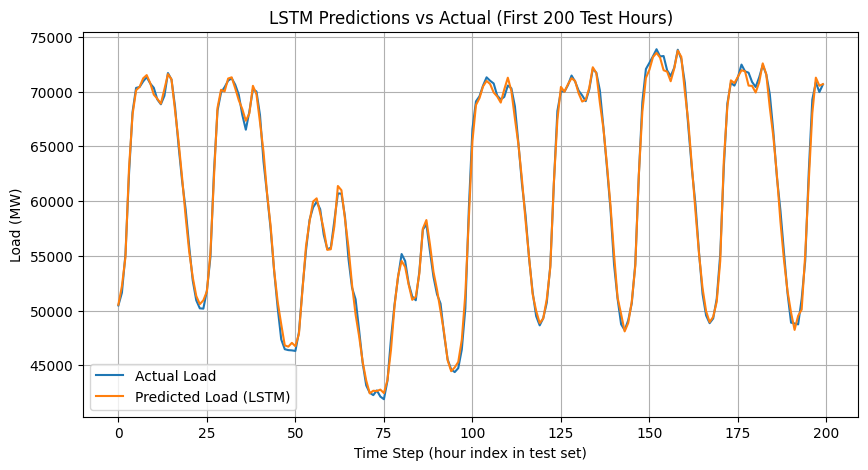

In [12]:
# Plotting Training Curves and Evaluation

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 1) Plot training and validation loss
plt.figure(figsize=(8, 5))
plt.plot(history_lstm.history["loss"], label="Train Loss")
plt.plot(history_lstm.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("LSTM Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# 2) Evaluate on the test set (in scaled units)
test_loss, test_mae = baseline_lstm.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE (scaled): {test_loss:.4f}")
print(f"Test MAE (scaled): {test_mae:.4f}")

# 3) Make predictions on the test set (scaled)
y_pred_scaled = baseline_lstm.predict(X_test).squeeze()

# Helper function to invert scaling just for the load column
def inverse_scale_load(y_scaled, scaler, target_idx):
    """
    y_scaled: 1D array of scaled load values
    scaler: fitted MinMaxScaler
    target_idx: column index of the load in the original scaled feature set
    """
    y_scaled = np.asarray(y_scaled)
    zeros = np.zeros((len(y_scaled), scaler.n_features_in_))
    zeros[:, target_idx] = y_scaled
    inv = scaler.inverse_transform(zeros)
    return inv[:, target_idx]

# 4) Inverse scale y_test and y_pred to MW
y_test_inv = inverse_scale_load(y_test, scaler, target_idx)
y_pred_inv = inverse_scale_load(y_pred_scaled, scaler, target_idx)

# 5) Compute MAE and RMSE in original MW units
mae_mw = mean_absolute_error(y_test_inv, y_pred_inv)
rmse_mw = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))


print(f"Test MAE (MW): {mae_mw:.2f}")
print(f"Test RMSE (MW): {rmse_mw:.2f}")

# 6) Plot a chunk of the predictions vs actual
N = 200  # number of hours to plot
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv[:N], label="Actual Load")
plt.plot(y_pred_inv[:N], label="Predicted Load (LSTM)")
plt.xlabel("Time Step (hour index in test set)")
plt.ylabel("Load (MW)")
plt.title("LSTM Predictions vs Actual (First 200 Test Hours)")
plt.legend()
plt.grid(True)
plt.show()


Starting LSTM hyperparameter tuning...

Training config: LSTM_32_lr1e-3
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
  -> Validation RMSE (scaled): 0.01428

Training config: LSTM_64_lr1e-3
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
  -> Validation RMSE (scaled): 0.01280

Training config: LSTM_64_lr5e-4
237/237 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
  -> Validation RMSE (scaled): 0.01631

Training config: LSTM_128_lr1e-3
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
  -> Validation RMSE (scaled): 0.01589



,name,units,lr,val_rmse_scaled
0,LSTM_32_lr1e-3,32,0.0010,0.014278
1,LSTM_64_lr1e-3,64,0.0010,0.012801
2,LSTM_64_lr5e-4,64,0.0005,0.016308
3,LSTM_128_lr1e-3,128,0.0010,0.015892


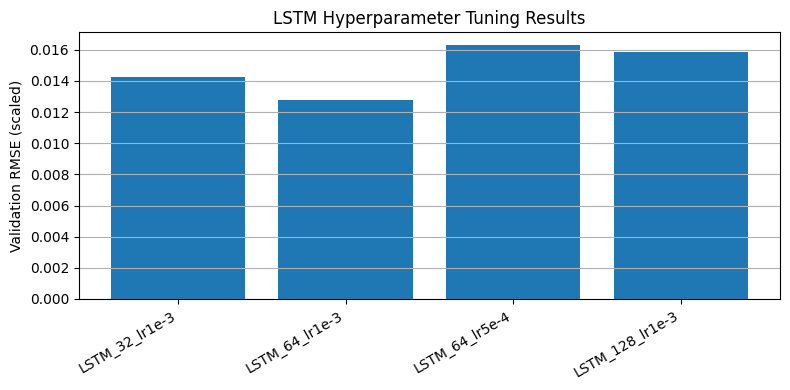

In [13]:
# --- Block 3: Lightweight LSTM Hyperparameter Tuning ---

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Helper: Build an LSTM with given hyperparameters
def build_lstm_model(units, lr, input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units, return_sequences=True),
        layers.LSTM(units // 2),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="mse",
        metrics=["mae"]
    )
    return model

# Configurations to test
configs = [
    {"name": "LSTM_32_lr1e-3",   "units": 32,  "lr": 1e-3},
    {"name": "LSTM_64_lr1e-3",   "units": 64,  "lr": 1e-3},
    {"name": "LSTM_64_lr5e-4",   "units": 64,  "lr": 5e-4},
    {"name": "LSTM_128_lr1e-3",  "units": 128, "lr": 1e-3},
]

results = []

print("Starting LSTM hyperparameter tuning...\n")

for cfg in configs:
    print(f"Training config: {cfg['name']}")
    model = build_lstm_model(cfg["units"], cfg["lr"], input_shape)

    # Early stopping
    es = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=3,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=25,
        batch_size=64,
        callbacks=[es],
        verbose=0
    )

    # Predict validation (scaled)
    val_pred_scaled = model.predict(X_val).squeeze()
    val_rmse_scaled = np.sqrt(mean_squared_error(y_val, val_pred_scaled))

    print(f"  -> Validation RMSE (scaled): {val_rmse_scaled:.5f}\n")

    results.append({
        "name": cfg["name"],
        "units": cfg["units"],
        "lr": cfg["lr"],
        "val_rmse_scaled": val_rmse_scaled
    })

# Convert to DataFrame for viewing
results_df = pd.DataFrame(results)
display(results_df)

# --- Plot results ---
plt.figure(figsize=(8, 4))
plt.bar(results_df["name"], results_df["val_rmse_scaled"])
plt.ylabel("Validation RMSE (scaled)")
plt.title("LSTM Hyperparameter Tuning Results")
plt.xticks(rotation=30, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()
